In [1]:
# Directories
import os
os.chdir(r"E:\academy\OneDrive - IIT Delhi\3. IIT DELHI\2. Research\JRF\1_PAPER\2_Analysis")
print(os.getcwd())

E:\academy\OneDrive - IIT Delhi\3. IIT DELHI\2. Research\JRF\1_PAPER\2_Analysis


In [2]:
#Array packages
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc4

from scipy.stats import kendalltau
import pymannkendall as mk

#plots
import matplotlib.pyplot as plt
import rioxarray as rio
import geopandas as gpd
from shapely.geometry import mapping

#Progress meter
from dask.diagnostics import ProgressBar
from tqdm import tqdm

# Directories
import os
import glob
import dask
#import h5netcdf
import scipy


# Teleconnection

In [3]:
mdl=4
model=["LIS_MERRA2","LIS_IMD","LIS_CHIRPS","LIS_ERA5","LIS_IMDc","LIS_IMDcnew"]
lsm_spi = xr.open_mfdataset(f'DATA_p/LIS/{model[mdl]}/{model[mdl]}_grid_SPI1.nc',engine='netcdf4', parallel=True,chunks={'time': 'auto'})

# Loading climatic oscillation
CO=pd.read_csv('DATA_r/3_Climate_oscillation/CO_new.csv')
CO['DATE'] = pd.to_datetime(CO.DATE,format='%d-%m-%Y')
CO.set_index('DATE', inplace=True)
enso = CO.loc[lsm_spi.time][['ENSO','ENSO_phase']]
xr_enso=xr.DataArray(np.array(enso["ENSO"]),coords=[lsm_spi.time.values],dims=["time"])
##el nino la nina
elnino=enso[enso["ENSO_phase"]=="EL NINO"].index
lanina=enso[enso["ENSO_phase"]=="LA NINA"].index


In [34]:
dt=pd.date_range(start='1980', end='2021', freq='M') 
#CO[:,'DATA']
np.sum(CO.loc[dt,['ENSO_phase']]=='NEUTRAL')
np.sum(CO.loc[dt,['ENSO_phase']]=='LA NINA')
#np.sum(CO.loc[dt,['ENSO_phase']]=='EL NINO')

ENSO_phase    157
dtype: int64

### 3 partitioning case

In [7]:
var=['TotalPrecip_tavg','Qs_tavg','RE_cleaned']
var1=['P','Q','RE']
ssn=['All','Monsoon','Winter']
var_ssn = [[a, b] for a in var1 for b in ssn]
ssn_m=[range(1,13),[5,6,7,8,9],[11,12,1,2,3]]

In [1]:

result=[]

for vr in range(3):
    for ss in range(3):
    
        ds=lsm_spi[var[vr]]  

        elnino1=elnino[elnino.month.isin(ssn_m[ss])]
        lanina1=lanina[lanina.month.isin(ssn_m[ss])]
    
        ppt_la=ds.sel(time=lanina1).mean(dim='time')
        ppt_el=ds.sel(time=elnino1).mean(dim='time')
        
        xrr1 = ppt_la-ppt_el
      
        xrr2=test(ds,elnino1, lanina1)

        xrr1=xrr1.where(xrr2<0.05)
   
        result.append(xrr1)

    

## 3x3
vmin1 =-0.6
vmax1=0.6
cmap2='RdBu'

Multiple_plot(result,vmin1,vmax1,cmap2,var_ssn)
plt.savefig(f'4_Teleconnection/outputs/3case_{model[mdl]}new.jpeg', bbox_inches='tight')
plt.show()

NameError: name 'lsm_spi' is not defined

<Figure size 350x262.5 with 0 Axes>

### 2 full Seasonal

In [50]:
var=['TotalPrecip_tavg','Evap_tavg','Qs_tavg','RE_cleaned']
var1=['P','ET','Q','RE']
ssn=['Pre-monsoon','Monsoon','Post-monsoon','Winter']
var_ssn = [[a, b] for a in var1 for b in ssn]
ssn_m=[[3,4,5],[6,7,8,9],[10,11],[12,1,2]]


In [51]:
result=[]
for vr in range(4):
    for ss in range(4):
        
        ds=lsm_spi[var[vr]]        
        lsm_ssn = ds.sel(time=ds['time.month'].isin(ssn_m[ss]))

        elnino1=elnino[elnino.month.isin(ssn_m[ss])]
        lanina1=lanina[lanina.month.isin(ssn_m[ss])]
        
        ppt_la=lsm_ssn.sel(time=lanina1).mean(dim='time')
        ppt_el=lsm_ssn.sel(time=elnino1).mean(dim='time')
        
        xrr1 = ppt_la-ppt_el
        
        xrr2=test(ds,elnino1, lanina1)
        xrr1=xrr1.where(xrr2<0.05)
        
        result.append(xrr1)

C:\Users\sstar\AppData\Local\Temp\ipykernel_8940\3186602326.py:12: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  _, p_value = ttest_ind(arr1, arr2, axis=0)
C:\Users\sstar\AppData\Local\Temp\ipykernel_8940\3186602326.py:12: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  _, p_value = ttest_ind(arr1, arr2, axis=0)
C:\Users\sstar\AppData\Local\Temp\ipykernel_8940\3186602326.py:12: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  _, p_value = ttest_ind(arr1, arr2, axis=0)
C:\Users\sstar\AppData\Local\Temp\ipykernel_8940\3186602326.py:12: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic ca

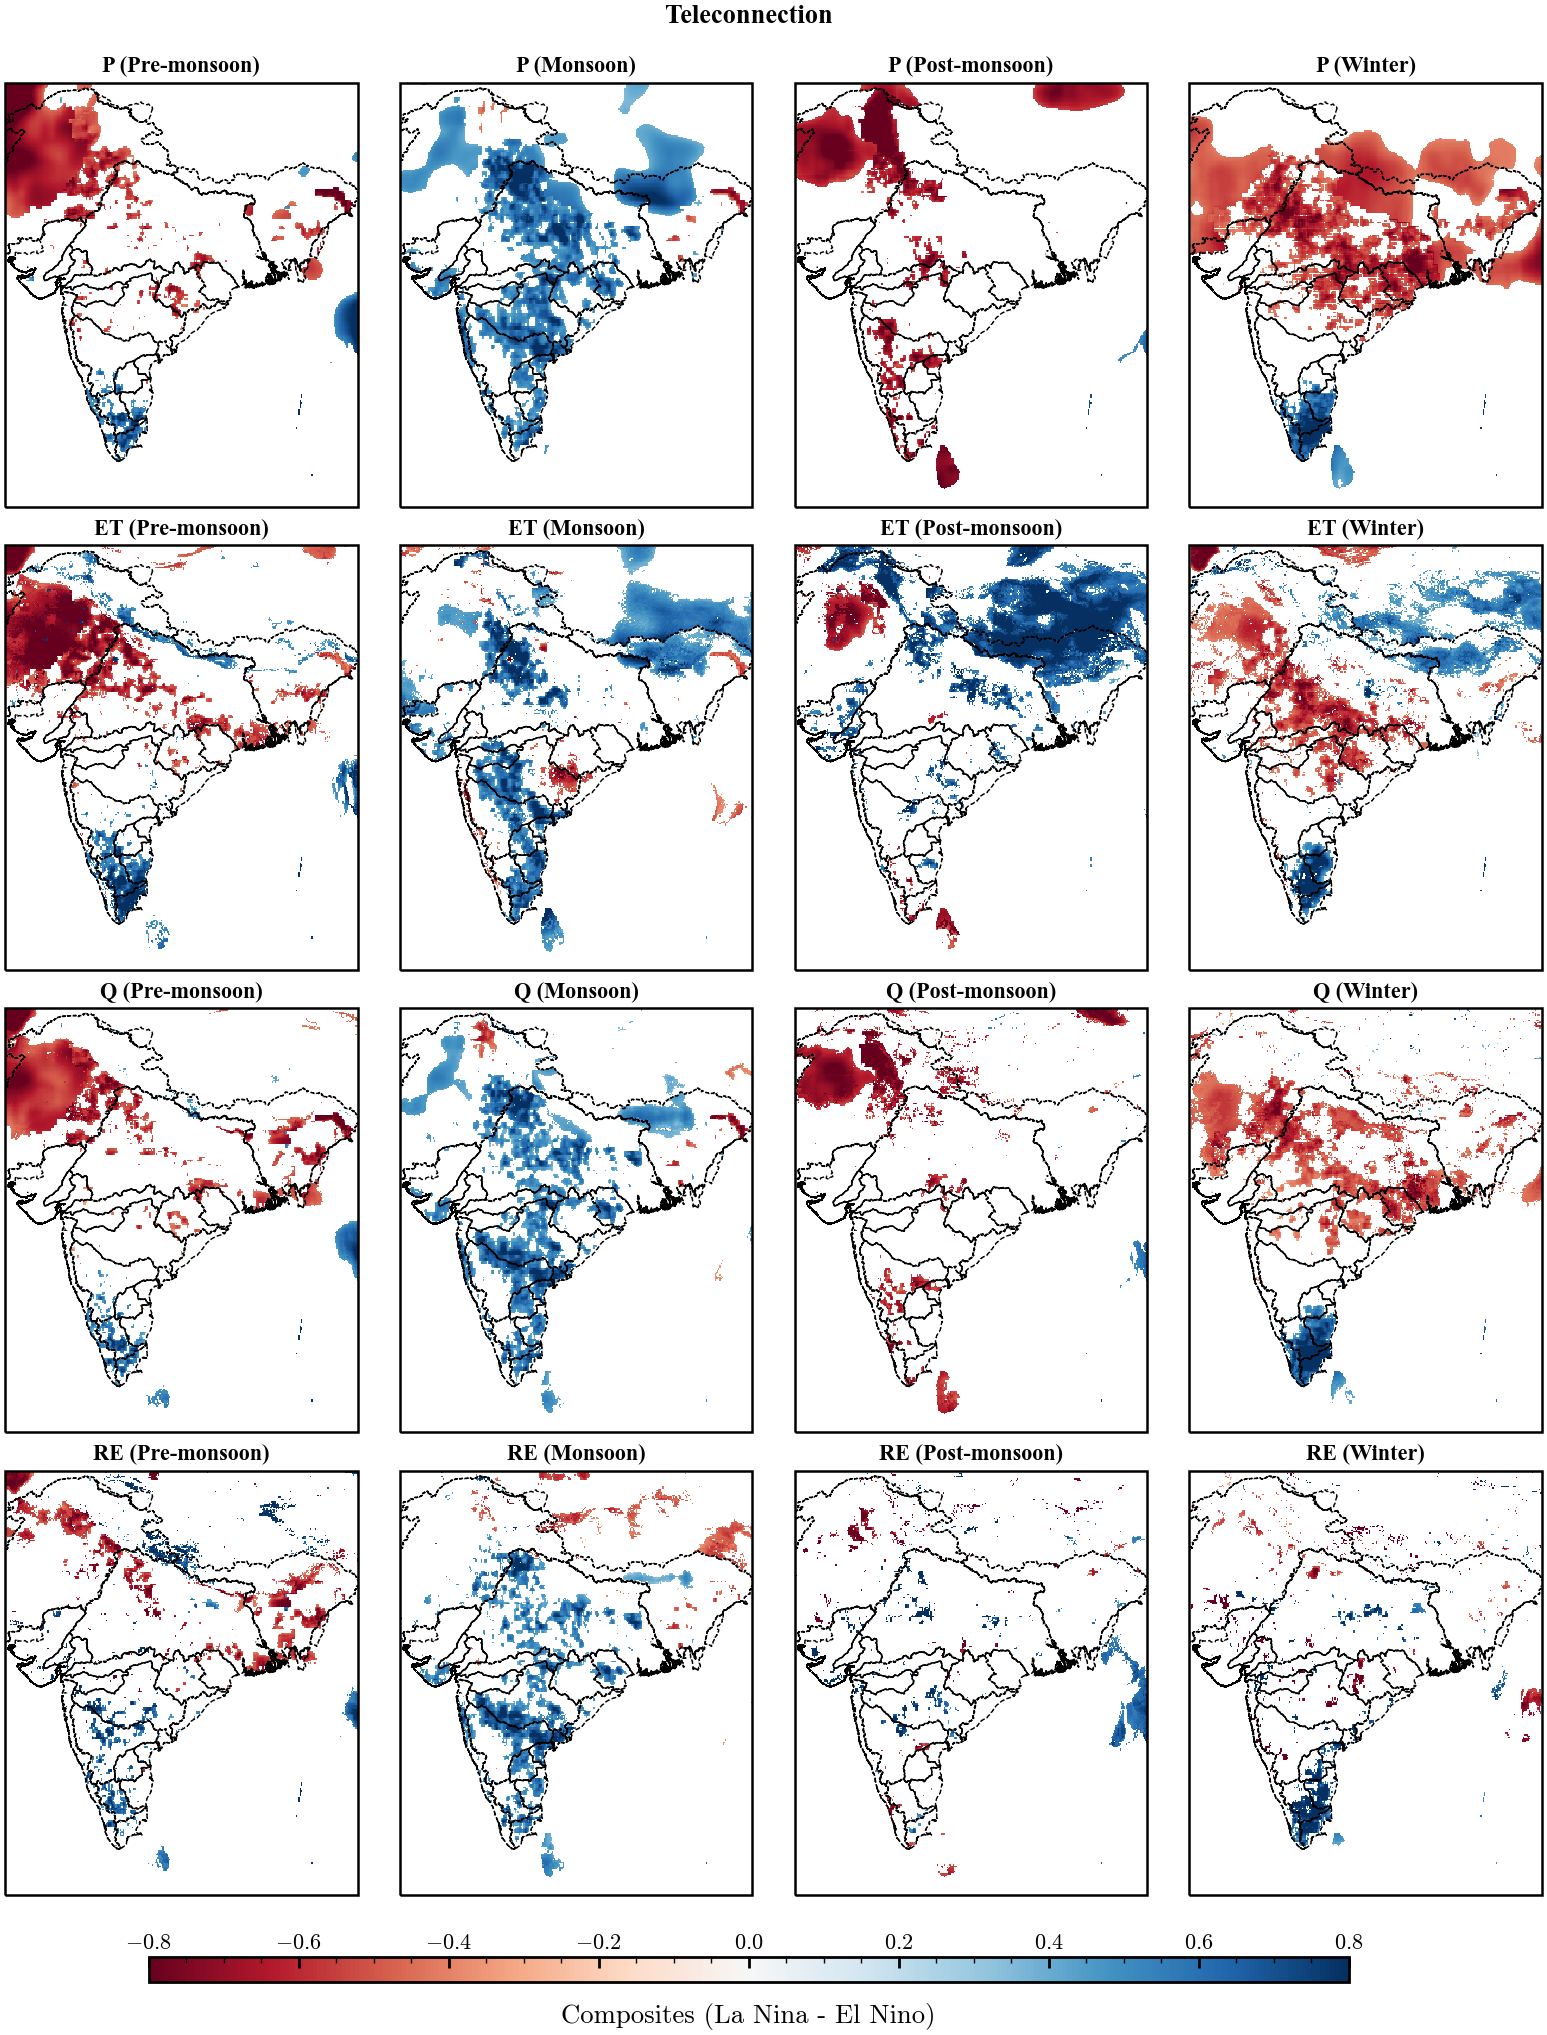

In [46]:
cbar_tit=f"Composites (La Nina - El Nino)"
Map_plot2(result,[4,4],var_ssn,cbar_tit)  
plt.savefig(f'4_Teleconnection/outputs/all_season_{model[mdl]}.jpeg', bbox_inches='tight')
plt.show()

# FUNCTIONS

In [1]:
def get_sub(x): 
    normal = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+-=()"
    sub_s = "ₐ₈cdₑբGₕᵢⱼₖₗₘₙₒₚQᵣₛₜᵤᵥwₓᵧZₐ♭꜀ᑯₑբ₉ₕᵢⱼₖₗₘₙₒₚ૧ᵣₛₜᵤᵥwₓᵧ₂₀₁₂₃₄₅₆₇₈₉₊₋₌₍₎"
    res = x.maketrans(''.join(normal), ''.join(sub_s)) 
    return x.translate(res) 
  
# display subscript 
print('H{}SO{}'.format(get_sub('2'),get_sub('4'))) #H₂SO₄ 

H₂SO₄


In [2]:
## T test
def test (ds,elnino1,lanina1):
    ppt_el=ds.where(ds["time"].isin(elnino1))
    ppt_la=ds.where(ds["time"].isin(lanina1))
    
    from scipy.stats import ttest_ind
    # Define a t-test function
    def t_test(arr1, arr2):
        # Perform independent t-test along the 'time' dimension
        arr1=arr1[~np.isnan(arr1)]
        arr2=arr2[~np.isnan(arr2)]
        _, p_value = ttest_ind(arr1, arr2, axis=0)
        return p_value
    
    # Apply the t-test function to the DataArrays
    p_value = xr.apply_ufunc(
        t_test,
        ppt_la.compute(),
        ppt_el.compute(),
        input_core_dims=[['time'],['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float]
    )
    
    return p_value

In [17]:
def Multiple_plot(data,vmin1,vmax1,cmap2,labls):

    import numpy as np 
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import geopandas as gpd
    import matplotlib
    import xarray as xr
    from matplotlib.colors import LinearSegmentedColormap
    import matplotlib.colors as clr
    import scienceplots
    import dask
  
    plt.style.use(['science','no-latex','bright'])


    # Define the figure and each axis for the 3 rows and 3 columns
    fig, axs = plt.subplots(3,3,subplot_kw={'projection': ccrs.PlateCarree()},figsize=(15.283,17),constrained_layout=False)
    axs=axs.flatten()

    acron=['a','b','c','d','e','f','g','h','i']

    #Loop over all of the models
    for i,model in enumerate(range(9)):

        
        #STEP 3 : LoaDING DATA
        xrr=data[i]
        basin_map = gpd.read_file('data_p/Shapefiles/Indian_basin/India_transboundary.shp')
        ind_map = gpd.read_file('data_p/Shapefiles/Indian_map/India_country.shp')
        
        
        
        # AXIS SETTING
        axs[i].set_extent([67.90, 97.59,5.4, 37.50], ccrs.PlateCarree())
       
        [x.set_linewidth(1.8) for x in axs[i].spines.values()]        #bOUNDARY WIDTHH 
        
        #cmap1 = clr.LinearSegmentedColormap.from_list('blue_to_white', ['lightskyblue', '#FFFFFF'], N=256)
        #gradient = np.linspace(0, 1, 256).reshape(-1, 1)
        #axs[i].imshow(gradient, cmap=cmap1, extent=[67.90, 97.59,4.5, 37.50], transform=ccrs.PlateCarree())    
   
  


        # Adding Mainplo
        Main_plot=xrr.plot(vmin=vmin1,vmax=vmax1 ,ax=axs[i], cmap=cmap2, add_labels=False, add_colorbar=False,linewidth=4) 


        # Adding addition feature 
        axs[i].add_feature(cfeature.OCEAN,facecolor=("white"))#e0f3f8
        axs[i].add_feature(cfeature.LAND, linewidth=1, facecolor='white', edgecolor='black')
        basin_map.plot(ax=axs[i],color = 'none',edgecolor = 'black',linewidth=0.6,linestyle='--')
        ind_map.plot(ax=axs[i],color = 'none',edgecolor = 'black',linewidth=0.6,linestyle='--')


        # Title each subplot with the name of the model
        if i in [0,1,2]:
            axs[i].set_title(f"{labls[i][1]}",fontsize=19,pad=12.5,fontname='Times New Roman',weight='bold')

        axs[i].text(0.94, 0.94, f'({acron[i]})', fontsize=19.5, color='black',fontname='Times New Roman',weight='bold',
             transform=axs[i].transAxes, ha='center', va='center')

    # Adjust the location of the subplots on the page to make room for the colorbar
    fig.subplots_adjust(bottom=0.1, left=None, top=None, right=None, wspace=0.10, hspace=0.12)  

    # Add a colorbar axis at the bottom of the graph
    cbar_ax = fig.add_axes([0.2, 0.042, 0.6, 0.014])

    # Draw the colorbar
    cbar=fig.colorbar(Main_plot, cax=cbar_ax,orientation='horizontal') #,ticks=[0, 1,5]
    cbar.outline.set_linewidth(2) 
    cbar.ax.tick_params(axis='both',which='both', labelsize=17,width=1.5, length=9) 
    cbar.ax.tick_params(axis='both',which='minor', labelsize=11,width=0.6, length=5) 
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')

    #cbar.set_label(f"{labls[0][0]}{get_sub('La Nina')} - {labls[0][0]}{get_sub('El Nino')}", fontsize=24, labelpad=-65,weight="bold")#position=(0.5, -0.5)
    cbar.set_label(f"Composite (La Nina - El Nino)", fontsize=27, labelpad=-65,weight="bold")#position=(0.5, -0.5)

    lb_nm=['Precipitation','Runoff','Runoff Efficiency']
    for idx, lb in enumerate([0, 3, 6]):
        axs[lb].text(-0.1, 0.5, lb_nm[idx], fontsize=21, rotation=90, fontname='Times New Roman', weight='bold', ha='center', va='center', transform=axs[lb].transAxes)
    #plt.show()



### 4X4 PLOT

In [15]:
def Map_plot2(xrr,col_row,plt_tit,cbar_tit):

    import numpy as np 
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import geopandas as gpd
    import matplotlib
    import xarray as xr
    from matplotlib.colors import LinearSegmentedColormap
    import matplotlib.colors as clr
    import scienceplots
    import dask
    plt.style.use(['science','no-latex','bright'])

    
    c=col_row[1]
    r=col_row[0]
    # Define the parameters
    B=5   # THis is the base scale. one figure dimension. All are determined based on this

    bt = 1.5  # bottom space
    
    fig_len=c*5 
    fig_hg=r*5.2 +bt   #This 1.15 depend on the subplot dimension. This case, height of subplot more than length
    fnt = B*3.2
    pd = B*1.5
    ln_wd = B*0.2
    
    fig, axs = plt.subplots(col_row[0],col_row[1],subplot_kw={'projection': ccrs.PlateCarree()},figsize=(fig_len,fig_hg),constrained_layout=False)
    axs=axs.flatten()

    #Adding feature maps
    basin_map = gpd.read_file('DATA_p/Shapefiles/Indian_basin/India_transboundary.shp')
    ind_map = gpd.read_file('DATA_p/Shapefiles/Indian_map/India_country.shp')

    #define plot variables
    vmin1 =-0.8
    vmax1= 0.8
    cmap2='RdBu'

    #Loop over all of the models
    for i,model in enumerate(range(len(xrr))):

            # Axis setttings
            data=xrr[i].compute()

            axs[i].set_extent([67.90, 97.59,4.5, 37.50], ccrs.PlateCarree())
            [x.set_linewidth(1.8) for x in axs[i].spines.values()]        #bOUNDARY WIDTHH 

            #cmap1 = clr.LinearSegmentedColormap.from_list('blue_to_white', ['lightgrey', '#FFFFFF'], N=256)
            #gradient = np.linspace(0, 1, 256).reshape(-1, 1)
            #axs[i].imshow(gradient, cmap=cmap1, extent=[67.90, 97.59,4.5, 37.50], transform=ccrs.PlateCarree())    

            axs[i].set_title(f"{plt_tit[i][0]} ({plt_tit[i][1]})",fontsize=fnt,pad=pd,fontname='Times New Roman',weight='bold')

            # Adding Mainplo
            Main_plot=data.plot(vmin=vmin1,vmax=vmax1 ,ax=axs[i], cmap=cmap2, add_labels=False, add_colorbar=False) 

            # Adding addition feature 
            basin_map.plot(ax=axs[i],color = 'none',edgecolor = 'black',linewidth=ln_wd,linestyle='--')



    # Adjust the location of the subplots on the page to make room for the colorbar
    fig.subplots_adjust(bottom=1.5/fig_hg, left=None, top=None, right=None, wspace=1.6/fig_len, hspace=2/fig_hg)  # First lock bottom, while make others None (automatically select), Then change spaces

    # Add a colorbar axis at the bottom of the graph
    cbar_ax = fig.add_axes([0.2, 0.63/fig_hg, 0.6, 0.25/fig_hg])   # left,bottom, widht, height

    # Draw the colorbar
    cbar=fig.colorbar(Main_plot, cax=cbar_ax,orientation='horizontal') #,ticks=[0, 1,5]
    cbar.outline.set_linewidth(2) 
    cbar.ax.tick_params(axis='both',which='both', labelsize=fnt,width=2, length=8) 
    cbar.ax.tick_params(axis='both',which='minor', labelsize=fnt*0.7,width=1, length=4) 
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')

    cbar.set_label(cbar_tit, fontsize=fnt*1.2, labelpad=-65,weight="bold")#position=(0.5, -0.5)
    cbar.ax.xaxis.label.set_fontweight('bold')

    fig.suptitle('Teleconnection', fontsize=19, y=0.915, fontweight='bold', fontname='Times New Roman')
    
    #plt.tight_layout()  
    #plt.show()

# Testing 

In [144]:
lsm_anom.isel(lat=100,lon=50)

<xarray.DataArray 'TotalPrecip_tavg' (time: 504, month: 12)>
array([[ 0.74369604,  0.5737803 ,  0.60506373, ...,  0.73984769,
         1.06867355,  1.16546687],
       [-0.2869141 , -0.22136148, -0.23343047, ..., -0.28542943,
        -0.41228875, -0.44963111],
       [-0.12413233, -0.09577123, -0.10099283, ..., -0.12348999,
        -0.17837521, -0.19453124],
       ...,
       [ 2.73727645,  2.11187802,  2.22702101, ...,  2.72311207,
         3.93340128,  4.28966251],
       [-0.29395933, -0.22679706, -0.2391624 , ..., -0.2924382 ,
        -0.42241257, -0.46067189],
       [ 0.48017616,  0.37046805,  0.39066657, ...,  0.47769143,
         0.69000174,  0.75249749]])
Coordinates:
  * time     (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2021-12-31
    lat      float64 31.5
    lon      float64 79.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [163]:
aa=pd.DataFrame({'date':enso.index,'ppt':lsm_M['TotalPrecip_tavg'].isel(lat=100,lon=50),'ppt_norm':lsm_norm.isel(lat=100,lon=50)})
aa.to_csv('aa.csv')